### Initializing the optimizer

In [52]:
import torch
import math
from collections import defaultdict

class GradientPredictionModel:
    def __init__(self, alpha):
        self.alpha = alpha
        self.prev_grad = None

    def predict(self, grad):
        if self.prev_grad is None or self.prev_grad.size() != grad.size():
            self.prev_grad = torch.zeros_like(grad)
        predicted_grad = self.alpha * self.prev_grad + (1 - self.alpha) * grad
        self.prev_grad = predicted_grad.detach()
        return predicted_grad

def compute_gradient_change_rate(grad, prev_grad):
    if prev_grad is None or prev_grad.size() != grad.size():
        return 0
    change_rate = torch.norm(grad - prev_grad) / (torch.norm(prev_grad) + 1e-8)
    return change_rate.item()

def compute_dynamic_beta(change_rate, min_val, max_val):
    beta = min_val + (max_val - min_val) * (1 - change_rate)
    return min(max(beta, min_val), max_val)

class BGE_Adam():
    def __init__(self, params, lr=0.001, alpha=0.5, betas=(0.9, 0.999), eps=1e-8, weight_decay=0,
                 entropy_weight=0.01, amsgrad=False, beta1_max=0.9, beta1_min=0.5, beta2_max=0.999,
                 beta2_min=0.9):
        self.defaults = dict(lr=lr, alpha=alpha, betas=betas, eps=eps, weight_decay=weight_decay,
                        entropy_weight=entropy_weight, amsgrad=amsgrad,
                        beta1_max=beta1_max, beta1_min=beta1_min,
                        beta2_max=beta2_max, beta2_min=beta2_min)
        self.gradient_prediction_model = {}
        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]
        for param_group in param_groups:
            param_group['params'] = list(param_group['params'])
            for name, default in self.defaults.items():
                param_group.setdefault(name, default)
            self.param_groups.append(param_group)

    def zero_grad(self, set_to_none: bool = False):
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        if set_to_none:
                            p.grad = None
                        else:
                            if p.grad.grad_fn is not None:
                                p.grad.detach_()
                            else:
                                p.grad.requires_grad_(False)
                            p.grad.zero_()

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                amsgrad = group['amsgrad']
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])

                # Compute beta1 and beta2 values dynamically based on gradient change rate
                prev_grad = state['exp_avg'] if 'exp_avg' in state else None
                gradient_change_rate = compute_gradient_change_rate(grad, prev_grad)
                beta1 = compute_dynamic_beta(gradient_change_rate, group['beta1_min'], group['beta1_max'])
                beta2 = compute_dynamic_beta(gradient_change_rate, group['beta2_min'], group['beta2_max'])

                # Update the moving averages of gradient and its square
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Prediction of next gradient (gradient_prediction_model)
                if p in self.gradient_prediction_model:
                    predicted_grad = self.gradient_prediction_model[p].predict(grad)
                else:
                    self.gradient_prediction_model[p] = GradientPredictionModel(group['alpha'])
                    predicted_grad = self.gradient_prediction_model[p].predict(grad)

                # Final parameter update with entropy adjustment
                entropy_adjustment = 1 + group['entropy_weight'] * torch.randn_like(p.data).mean()
                p.data.addcdiv_(predicted_grad, denom, value=-step_size * entropy_adjustment)

        return loss


In [68]:
import torch
import torch.optim as optim

threshold = 1e-7

def optimize(func_opti, optimizer, x, label, steps):
    prev_loss = float('inf')
    for step in range(steps):
        optimizer.zero_grad()
        loss = func_opti(x)
        loss.backward()
        optimizer.step()

        if step % (steps//4) == 0:
            x_values = [xi.detach().item() for xi in x]
            print(f"{label} Step {step}, x = {x_values}, f(x) = {loss.item()}")

        if abs(prev_loss - loss.item()) < threshold:
            x_values = [xi.detach().item() for xi in x]
            print(f"{label} converged at step {step}, x = {x_values}, minimum value = {loss.item()}")
            break
        prev_loss = loss.item()


### Tests on mulitple functions

Rosenbrock Function

In [72]:
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

# Using BGE Adam
x_BGE = torch.tensor([1.0, 2.5], requires_grad=True)
optimizer_BGE = BGE_Adam([x_BGE], lr=0.01)
optimize(rosenbrock, optimizer_BGE, x_BGE, "BGE Adam",100000)

# Using Adam Optimizer
x_Adam = torch.tensor([1.0, 2.5], requires_grad=True)
optimizer_Adam = optim.Adam([x_Adam], lr=0.01)
optimize(rosenbrock, optimizer_Adam, x_Adam, "Adam",100000)

# Using SGD
x_SGD = torch.tensor([1.0, 2.5], requires_grad=True)
optimizer_SGD = optim.SGD([x_SGD], lr=0.01)
optimize(rosenbrock, optimizer_SGD, x_SGD, "SGD",10)


BGE Adam Step 0, x = [1.0100009441375732, 2.4899990558624268], f(x) = 225.0
BGE Adam Step 20000, x = [0.9991745352745056, 0.9961960911750793], f(x) = 0.0008774029556661844
BGE Adam Step 40000, x = [0.9974825978279114, 0.9978703856468201], f(x) = 0.0007684807060286403
BGE Adam Step 60000, x = [0.9977865815162659, 0.997702419757843], f(x) = 0.0001327084464719519
BGE Adam Step 80000, x = [0.9979008436203003, 0.9974621534347534], f(x) = 0.0006920450832694769
BGE Adam converged at step 99999, x = [0.9979008436203003, 0.9974621534347534], minimum value = 0.006201299838721752
Adam Step 0, x = [1.0099999904632568, 2.490000009536743], f(x) = 225.0
Adam Step 20000, x = [0.999999463558197, 0.9999989867210388], f(x) = 1.6484591469634324e-12
Adam Step 40000, x = [0.9999989867210388, 0.9999985694885254], f(x) = 2.920685915341892e-11
Adam Step 60000, x = [0.9999997615814209, 0.999999463558197], f(x) = 4.121147867408581e-13
Adam Step 80000, x = [0.9999892711639404, 0.9999792575836182], f(x) = 2.642366

All the functions of comparison


Running SGD on Sphere Function...
Running Adam on Sphere Function...
Running BGE_Adam on Sphere Function...


C:\Users\lenovo\AppData\Local\Temp\ipykernel_1516\2590895680.py:136: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.diff(result['losses']) ** 2), label=f'{name}')


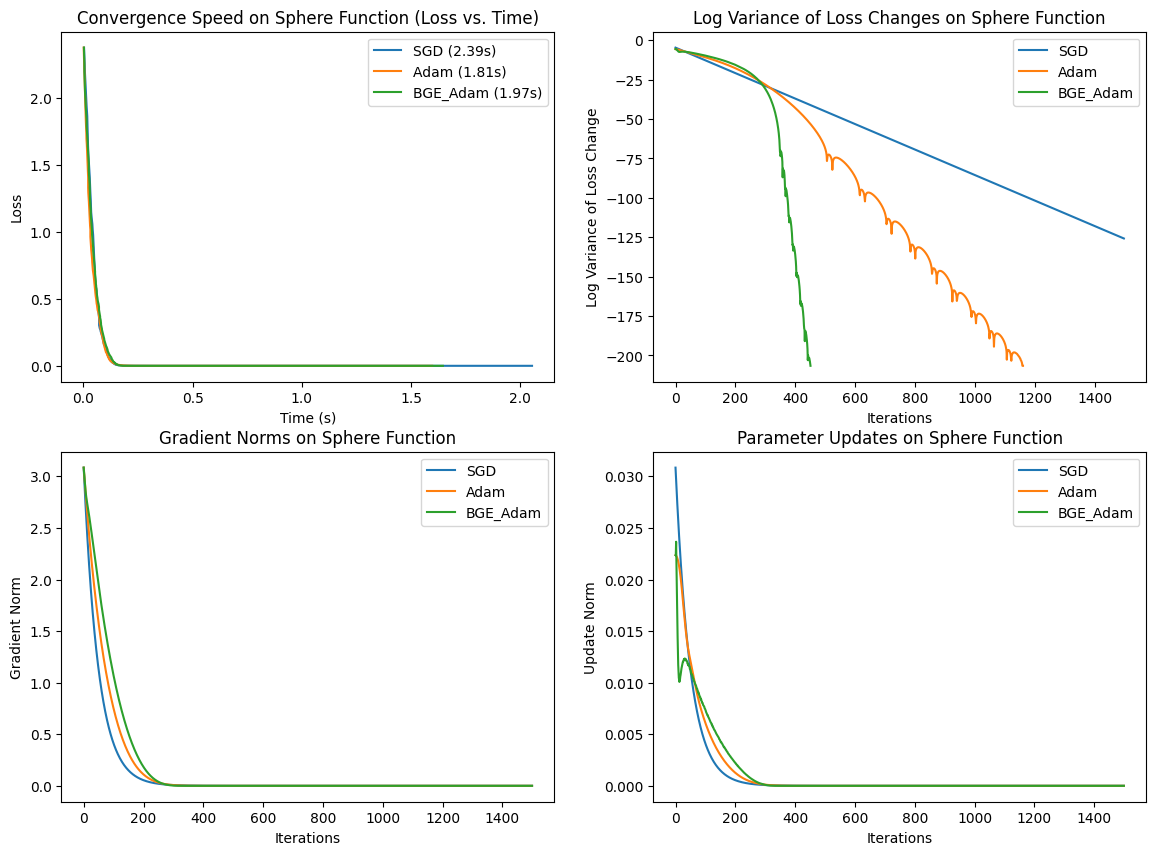

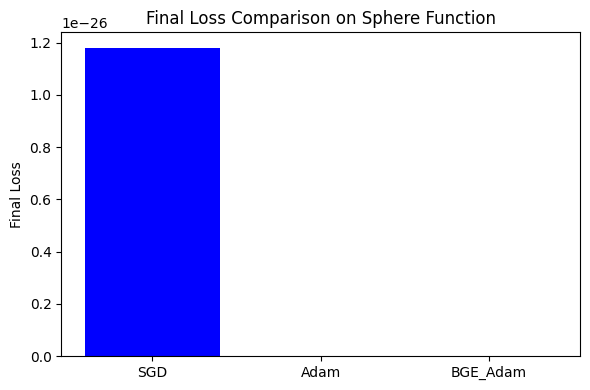

Running SGD on Ackley Function...
Running Adam on Ackley Function...
Running BGE_Adam on Ackley Function...


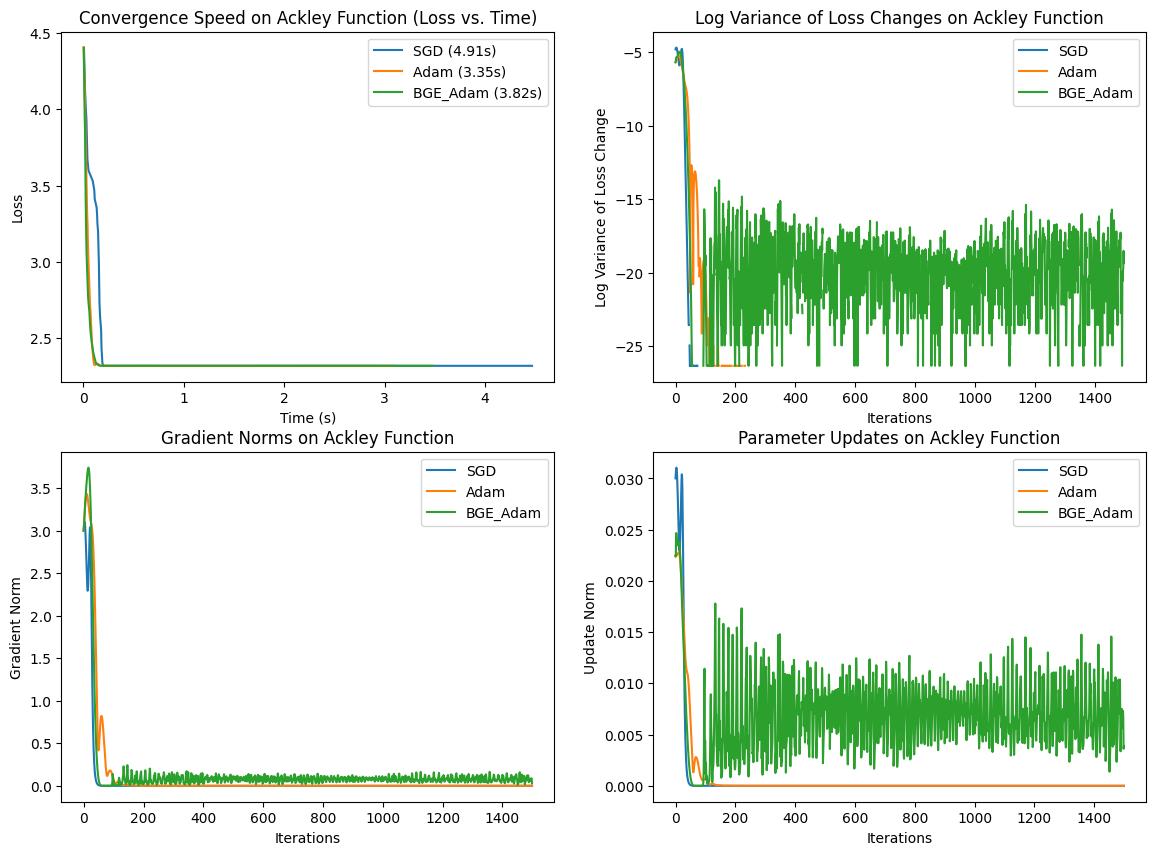

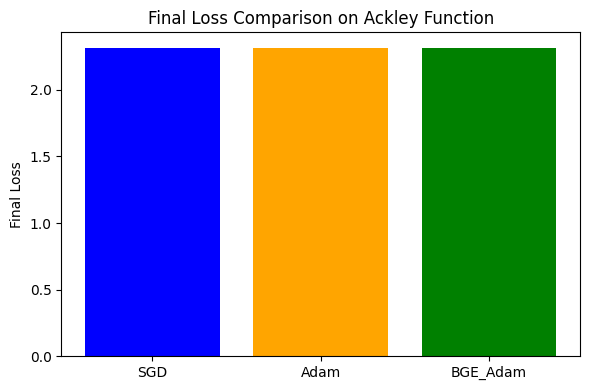

Running SGD on Rosenbrock Function...
Running Adam on Rosenbrock Function...
Running BGE_Adam on Rosenbrock Function...


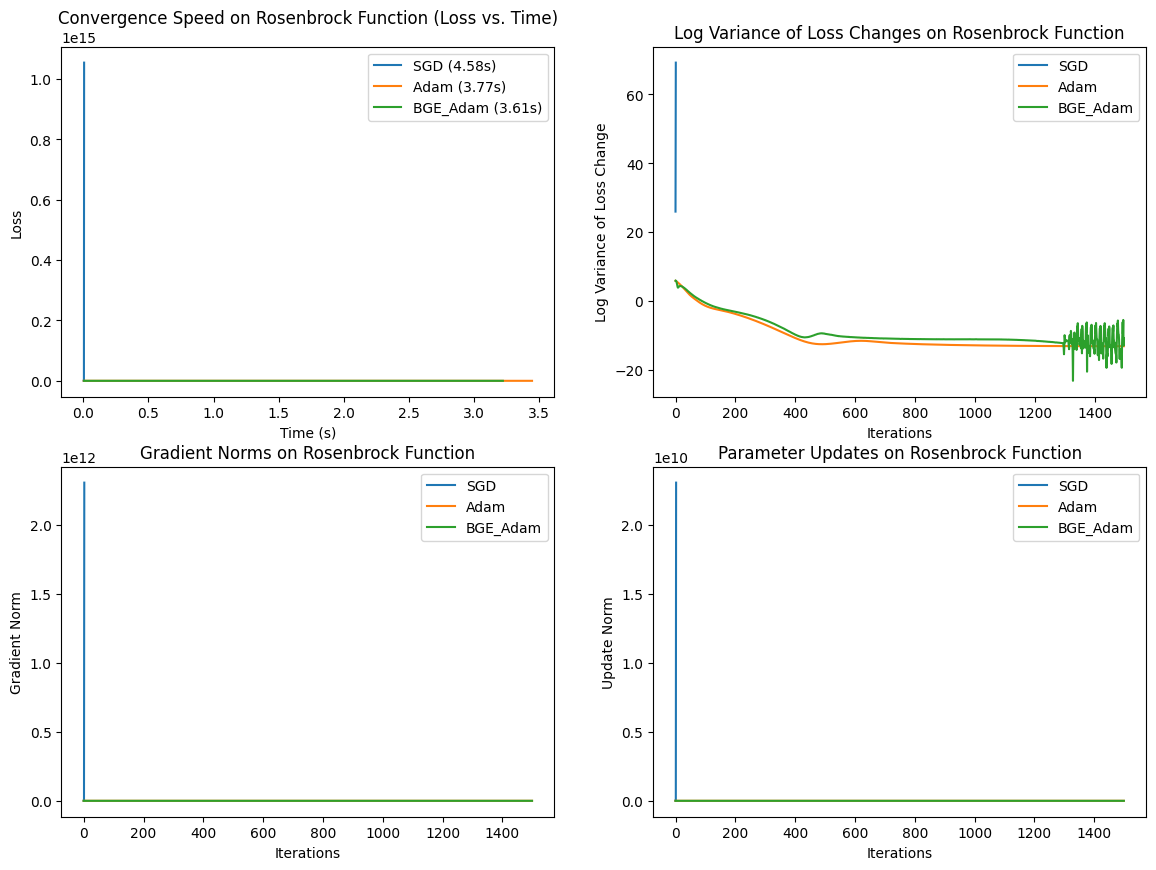

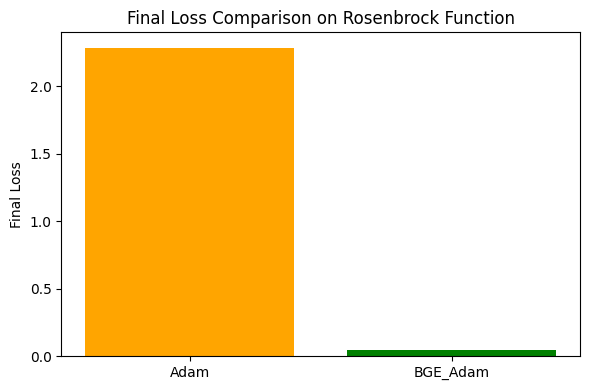

Running SGD on Rastrigin Function...
Running Adam on Rastrigin Function...
Running BGE_Adam on Rastrigin Function...


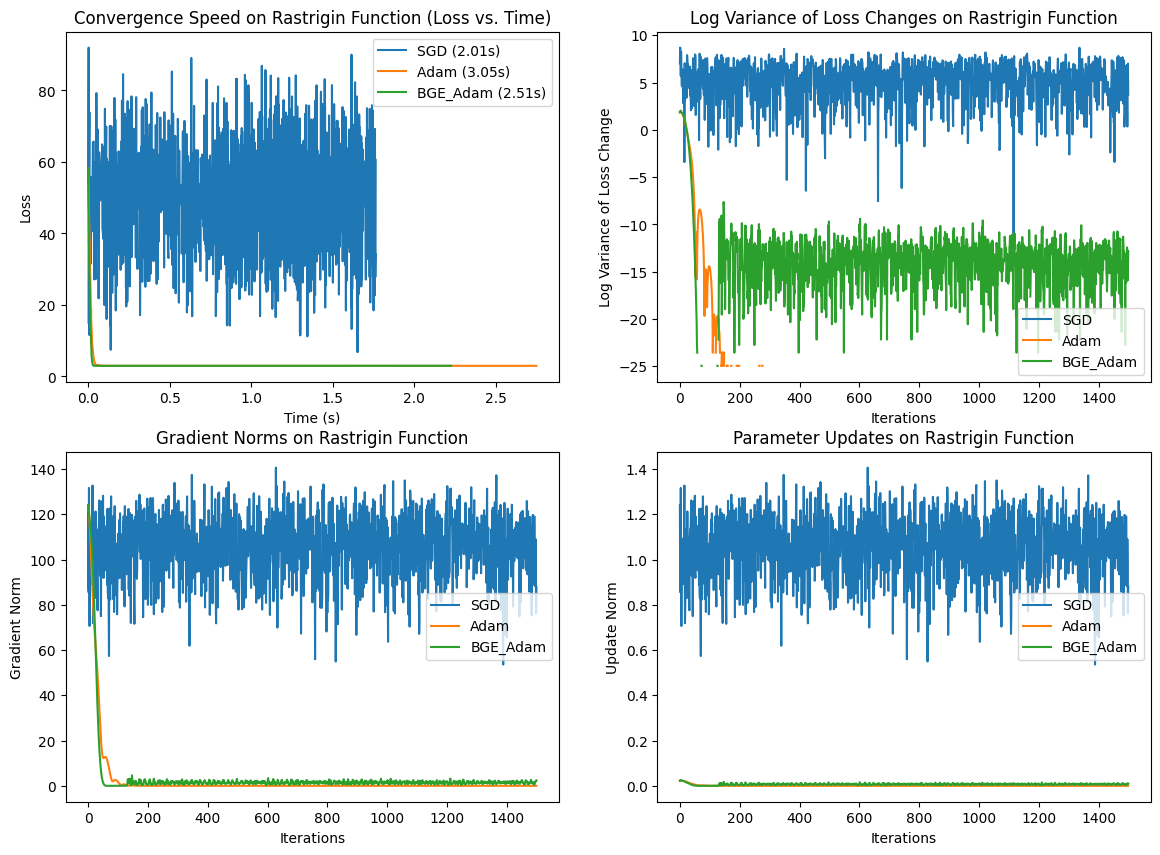

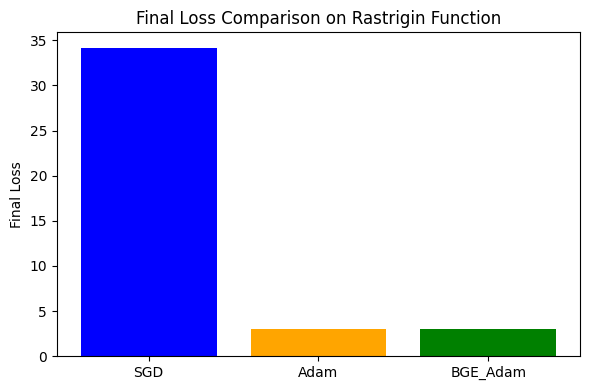

Running SGD on Beale Function...
Running Adam on Beale Function...
Running BGE_Adam on Beale Function...


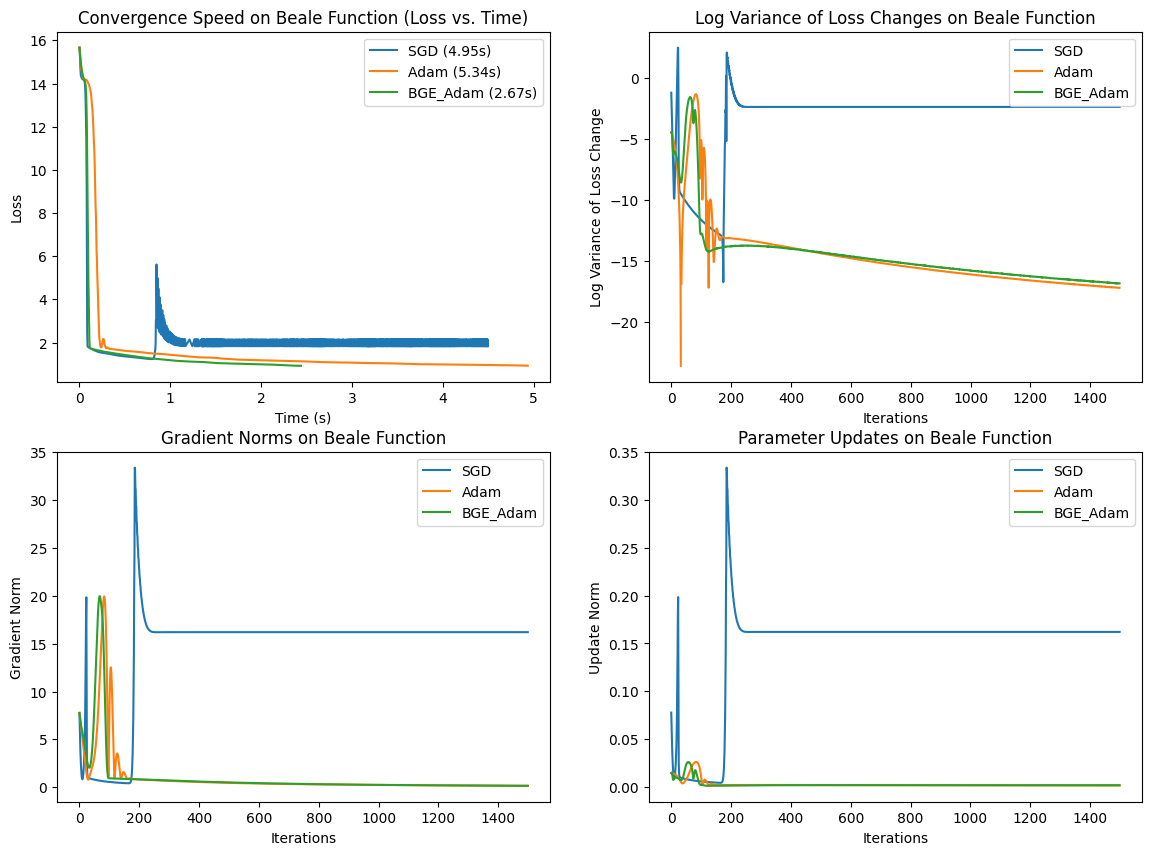

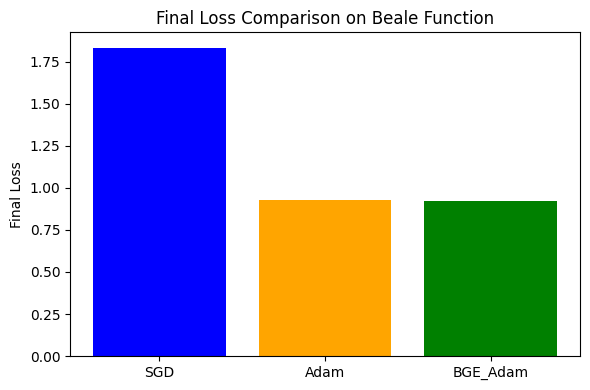

Running SGD on Booth Function...
Running Adam on Booth Function...
Running BGE_Adam on Booth Function...


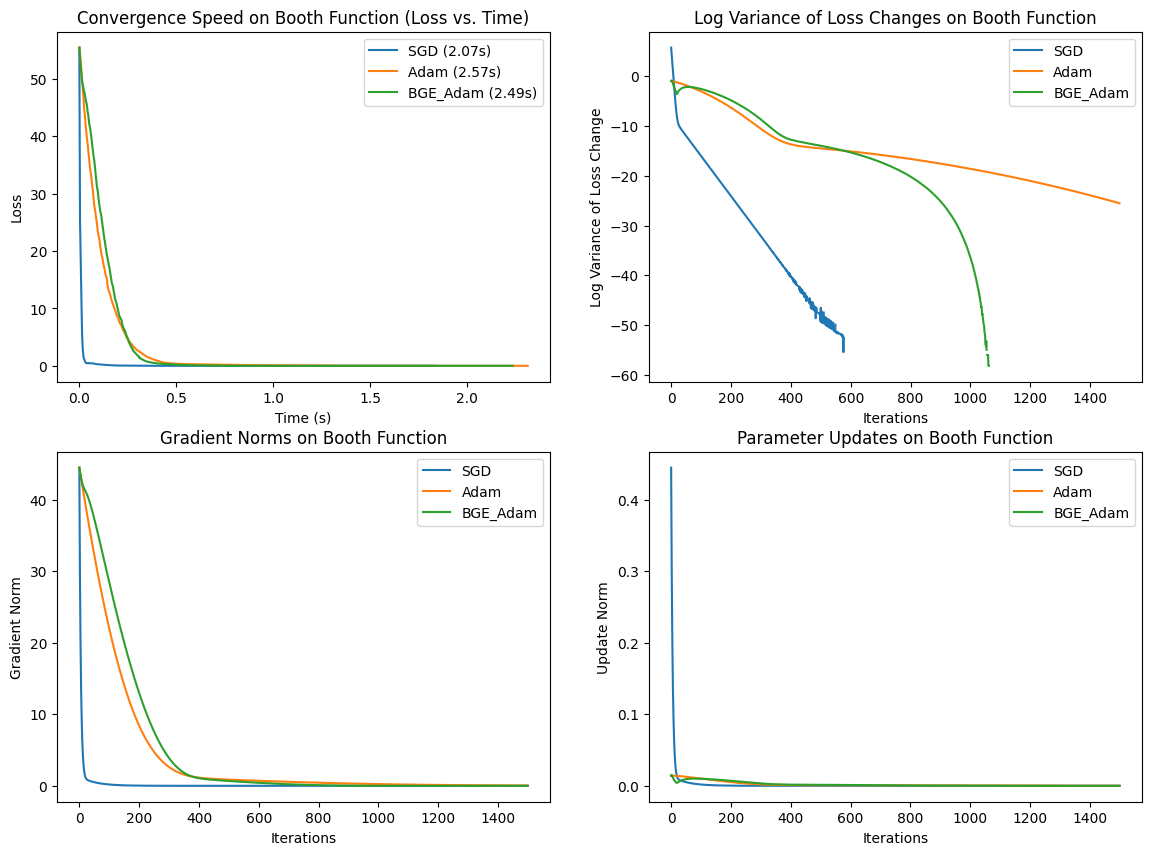

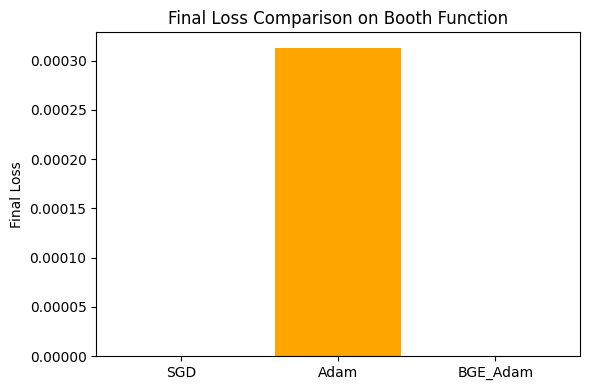

Running SGD on Goldstein-Price Function...
Running Adam on Goldstein-Price Function...
Running BGE_Adam on Goldstein-Price Function...


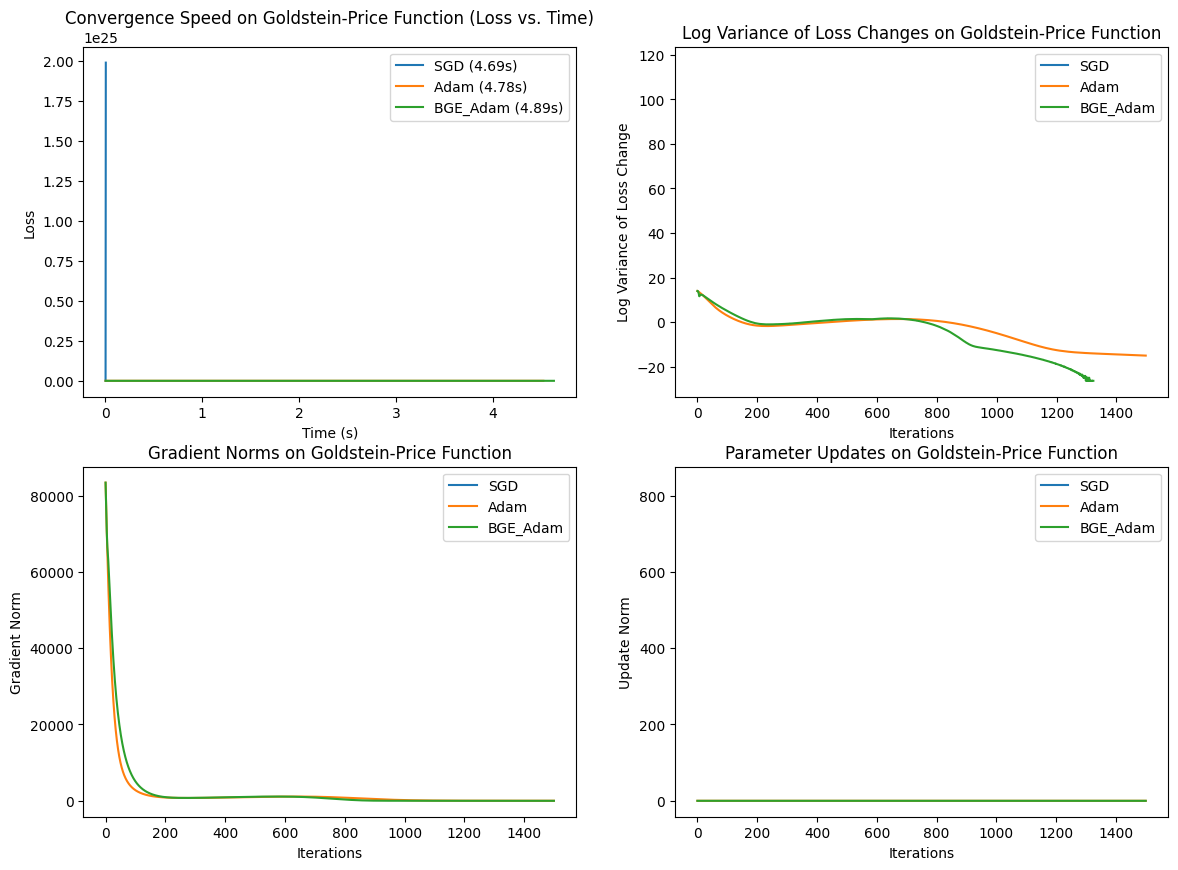

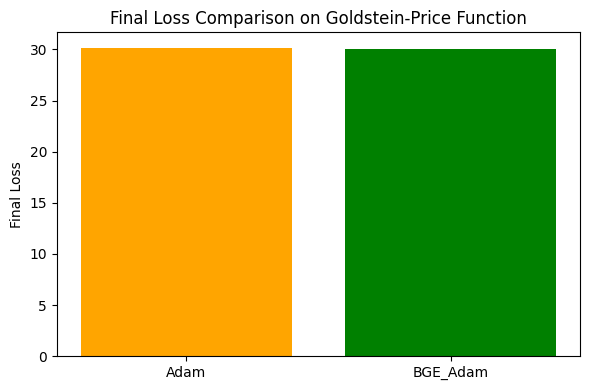

Running SGD on Bukin Function...
Running Adam on Bukin Function...
Running BGE_Adam on Bukin Function...


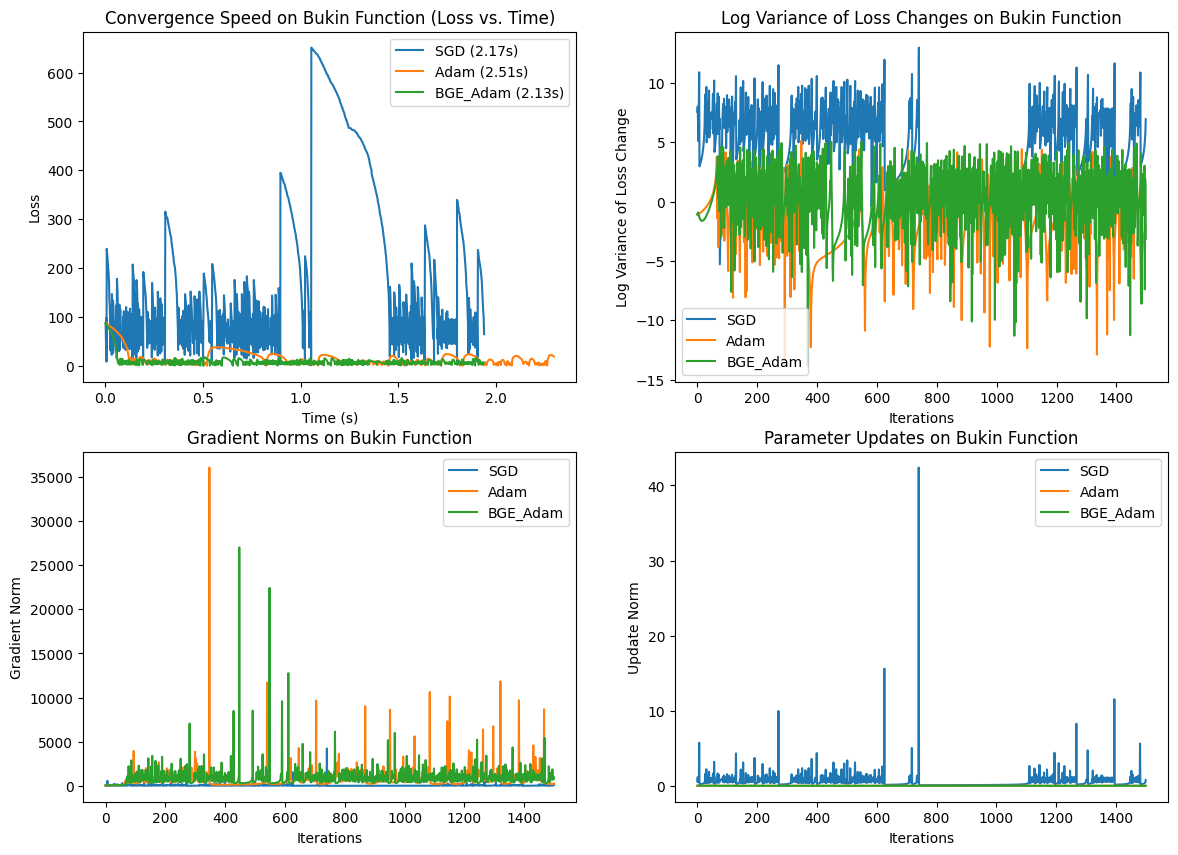

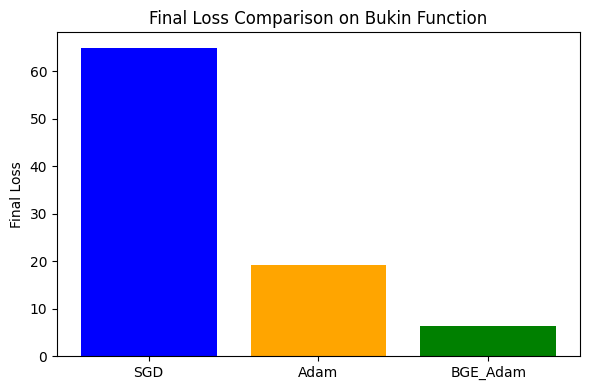

In [77]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# Benchmark functions
def sphere(x):
    return torch.sum(x ** 2)

def ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = x.size(0)
    sum1 = torch.sum(x ** 2)
    sum2 = torch.sum(torch.cos(c * x))
    term1 = -a * torch.exp(-b * torch.sqrt(sum1 / d))
    term2 = -torch.exp(sum2 / d)
    return term1 + term2 + a + torch.exp(torch.tensor(1.0))

def rosenbrock(x):
    return torch.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

def rastrigin(x):
    n = x.numel()
    return 10 * n + torch.sum(x**2 - 10 * torch.cos(2 * torch.pi * x))

def beale(x):
    x1, x2 = x[0], x[1]
    return (1.5 - x1 + x1 * x2)**2 + (2.25 - x1 + x1 * x2**2)**2 + (2.625 - x1 + x1 * x2**3)**2

def booth(x):
    x_0, x_1 = x[0], x[1]
    return (x_0 + 2*x_1 - 7)**2 + (2*x_0 + x_1 - 5)**2

def goldstein_price(x):
    x_0, x_1 = x[0], x[1]
    term1 = 1 + (x_0 + x_1 + 1)**2 * (19 - 14*x_0 + 3*x_0**2 - 14*x_1 + 6*x_0*x_1 + 3*x_1**2)
    term2 = 30 + (2*x_0 - 3*x_1)**2 * (18 - 32*x_0 + 12*x_0**2 + 48*x_1 - 36*x_0*x_1 + 27*x_1**2)
    return term1 * term2

def bukin(x):
    x_0, x_1 = x[0], x[1]
    return 100 * torch.sqrt(torch.abs(x_1 - 0.01 * x_0**2)) + 0.01 * torch.abs(x_0 + 10)

benchmark_functions = {
    'Sphere Function': sphere,
    'Ackley Function': ackley,
    'Rosenbrock Function': rosenbrock,
    'Rastrigin Function': rastrigin,
    'Beale Function': beale,
    'Booth Function': booth,
    'Goldstein-Price Function': goldstein_price,
    'Bukin Function': bukin
}

num_iterations = 1500
dim = 5
learning_rate = 0.01
initial_x = torch.randn(dim, requires_grad=True)

def run_optimizer(optimizer_class, func, x, **kwargs):
    optimizer = optimizer_class([x], **kwargs)
    losses = []
    times = []
    grad_norms = []
    param_updates = []
    prev_params = x.clone().detach()
    start_time = time.time()
    accumulated_time = 0

    for _ in range(num_iterations):
        iteration_start = time.time()

        optimizer.zero_grad()
        loss = func(x)
        loss.backward()
        optimizer.step()

        iteration_end = time.time()
        iteration_time = iteration_end - iteration_start
        accumulated_time += iteration_time

        with torch.no_grad():
            current_grad_norm = torch.norm(x.grad).item()
            grad_norms.append(current_grad_norm)

            update_norm = torch.norm(x - prev_params).item()
            param_updates.append(update_norm)
            prev_params = x.clone().detach()

        losses.append(loss.item())
        times.append(accumulated_time)

    end_time = time.time()
    return losses, times, grad_norms, param_updates, end_time - start_time

def compare_optimizers(func, func_name):
    x = initial_x.clone().detach().requires_grad_(True)
    optimizers = {
        'SGD': optim.SGD,
        'Adam': optim.Adam,
        'BGE_Adam': BGE_Adam
    }
    
    results = {}
    for name, opt_class in optimizers.items():
        print(f'Running {name} on {func_name}...')
        losses, times, grad_norms, param_updates, elapsed_time = run_optimizer(
            opt_class, func, x.clone().detach().requires_grad_(True), lr=learning_rate
        )
        results[name] = {
            'losses': losses,
            'times': times,
            'grad_norms': grad_norms,
            'param_updates': param_updates,
            'time': elapsed_time
        }
    
    # Plotting results
    plt.figure(figsize=(14, 10))
    
    # Convergence speed (Loss vs. Time)
    plt.subplot(2, 2, 1)
    for name, result in results.items():
        plt.plot(result['times'], result['losses'], label=f'{name} ({result["time"]:.2f}s)')
    plt.title(f'Convergence Speed on {func_name} (Loss vs. Time)')
    plt.xlabel('Time (s)')
    plt.ylabel('Loss')
    plt.legend()
    
    # Stability
    plt.subplot(2, 2, 2)
    for name, result in results.items():
        plt.plot(np.log(np.diff(result['losses']) ** 2), label=f'{name}')
    plt.title(f'Log Variance of Loss Changes on {func_name}')
    plt.xlabel('Iterations')
    plt.ylabel('Log Variance of Loss Change')
    plt.legend()

    # Gradient norms
    plt.subplot(2, 2, 3)
    for name, result in results.items():
        plt.plot(result['grad_norms'], label=f'{name}')
    plt.title(f'Gradient Norms on {func_name}')
    plt.xlabel('Iterations')
    plt.ylabel('Gradient Norm')
    plt.legend()
    
    # Parameters updating
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        plt.plot(result['param_updates'], label=f'{name}')
    plt.title(f'Parameter Updates on {func_name}')
    plt.xlabel('Iterations')
    plt.ylabel('Update Norm')
    plt.legend()

    # Final Loss 
    final_losses = [result['losses'][-1] for result in results.values()]
    plt.figure(figsize=(6, 4))
    plt.bar(results.keys(), final_losses, color=['blue', 'orange', 'green'])
    plt.title(f'Final Loss Comparison on {func_name}')
    plt.ylabel('Final Loss')

    plt.tight_layout()
    plt.show()

# Run comparisons on each functn
for func_name, func in benchmark_functions.items():
    compare_optimizers(func, func_name)
